In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
FICHEIRO_MESTRE = '../../data/analysis/complete_analysis.csv'
HIERARQUIA_PROMPTS = ['contextual', 'structured', 'detailed', 'minimum']

In [37]:
df_analise = pd.read_csv(FICHEIRO_DADOS_VALIDADOS)
df_analise.head(2)

,evaluation_id,response_A,response_B,evaluation_claude,evaluation_prometheus,evaluation_mistral,claude_winner,claude_total_score,mistral_winner,mistral_total_score,...,model,comparison,prompt_level_of_A,prompt_level_of_B,prompt_level,model_of_A,model_of_B,source_of_A,source_of_B,original_pt_response
0,TC014_gemini-1.5-pro-latest_1_Technical_contex...,The primary use of a NumPy array is to efficie...,Numple matrices are the central data structure...,"{\n ""winner"": ""A"",\n ""general_justificat...","{\n ""winner"": ""A"",\n ""general_ju...","{\n ""winner"": ""A"",\n ""general_j...",A,5.0,A,5.00,...,gemini-1.5-pro-latest,NaN,NaN,NaN,contextual,NaN,NaN,english_original,portuguese_pivoted,As matrizes NumPy são a estrutura de dados cen...
1,CG004_gemini-1.5-pro-latest_4_General Knowledg...,The Proclamation of the Republic in Brazil on ...,"The proclamation of the Republic in Brazil, on...","{\n ""winner"": ""A"",\n ""general_justificat...","{\n""winner"": ""Tie"",\n""general_justification"": ...","{\n ""winner"": ""A"",\n ""general_justification...",A,5.0,A,4.75,...,gemini-1.5-pro-latest,NaN,NaN,NaN,minimum,NaN,NaN,english_original,portuguese_pivoted,"A Proclamação da República no Brasil, em 15 de..."


In [38]:
if 'prompt_level_of_A' in df_analise.columns and 'prompt_level_of_B' in df_analise.columns:
    df_prompts = df_analise[df_analise['prompt_level_of_A'].notna() & df_analise['prompt_level_of_B'].notna()].copy()
    print(f"\n{len(df_prompts)} pares de comparação de prompts encontrados para a análise.")


500 pares de comparação de prompts encontrados para a análise.


In [39]:
# A análise principal será baseada no voto da maioria do comitê de LLMs
coluna_vencedor = 'gold_winner'

In [40]:
df_analise['comparacao_prompt'] = df_analise['evaluation_id'].apply(extrair_metadados_prompt)

In [41]:
def calcular_resultados_completos(df, p_menos, p_mais, idioma):
    # Filtra para a comparação e idioma corretos
    subset = df[
        (df['language'] == idioma) & 
        (((df['prompt_level_of_A'] == p_menos) & (df['prompt_level_of_B'] == p_mais)) |
            ((df['prompt_level_of_A'] == p_mais) & (df['prompt_level_of_B'] == p_menos)))
    ]
    if len(subset) == 0: return None
    
    total_pares = len(subset)
    vitorias_p_menos = 0
    vitorias_p_mais = 0
    
    for _, row in subset.iterrows():
        if row[coluna_vencedor] == 'A':
            if row['prompt_level_of_A'] == p_mais: vitorias_p_mais += 1
            else: vitorias_p_menos += 1
        elif row[coluna_vencedor] == 'B':
            if row['prompt_level_of_B'] == p_mais: vitorias_p_mais += 1
            else: vitorias_p_menos += 1
    
    empates = total_pares - vitorias_p_menos - vitorias_p_mais
    
    return {
        f'vitoria_{p_menos}': vitorias_p_menos / total_pares,
        f'vitoria_{p_mais}': vitorias_p_mais / total_pares,
        'empate': empates / total_pares
    }

In [42]:
# > H₁: Prompts mais específicos melhoram o desempenho em ambos os idiomas.
resultados_h1 = []
for i in range(len(HIERARQUIA_PROMPTS)):
    for j in range(i + 1, len(HIERARQUIA_PROMPTS)):
        p_menos, p_mais = HIERARQUIA_PROMPTS[i], HIERARQUIA_PROMPTS[j]
        for lang in ['en', 'pt']:
            taxas = calcular_resultados_completos(df_prompts, p_menos, p_mais, lang)
            if taxas is not None:
                resultados_h1.append({
                    'Comparacao': f"{p_mais} vs. {p_menos}",
                    'Idioma': lang.upper(),
                    f'Vitoria_{p_menos} (%)': taxas[f'vitoria_{p_menos}'],
                    f'Vitoria_{p_mais} (%)': taxas[f'vitoria_{p_mais}'],
                    'Empate (%)': taxas['empate']
                })

In [43]:
def calcular_taxa_vitoria(df, p_menos, p_mais, idioma):
    # Usa a coluna 'language_context' que criámos no notebook anterior
    lang_col = 'language_context'
    
    subset = df[(df[lang_col].str.upper() == idioma) & (df['prompt_A_nome'] == p_menos) & (df['prompt_B_nome'] == p_mais)]
    if len(subset) == 0: return np.nan
    
    # Como p_mais é sempre B na nossa lógica, contamos as vitórias de B
    vitorias_mais_especifico = (subset[coluna_vencedor] == 'B').sum()
    return vitorias_mais_especifico / len(subset)

In [44]:
resultados_h1 = []
for i in range(len(HIERARQUIA_PROMPTS)):
    for j in range(i + 1, len(HIERARQUIA_PROMPTS)):
        p_menos, p_mais = HIERARQUIA_PROMPTS[i], HIERARQUIA_PROMPTS[j]
        # A análise da H1 foca-se no desempenho DENTRO de cada idioma.
        # Por isso, iteramos apenas sobre 'EN' e 'PT'.
        for lang in ['EN', 'PT']:
            taxa = calcular_taxa_vitoria(df_prompts, p_menos, p_mais, lang)
            if not pd.isna(taxa):
                resultados_h1.append({'Comparacao': f"{p_mais} vs. {p_menos}", 'Idioma': lang, 'Taxa de Vitoria': taxa})

df_resultados_h1 = pd.DataFrame(resultados_h1)

KeyError: 'prompt_A_nome'

In [ ]:
print("\n" + "="*90)
print("RESULTADOS PARA H₁: Distribuição Completa de Resultados (Baseado no Comitê de LLMs)")
print("="*90)

df_resultados_h1 = pd.DataFrame(resultados_h1)
df_resultados_h1.head()


RESULTADOS PARA H₁: Distribuição Completa de Resultados (Baseado no Comitê de LLMs)


,Comparacao,Idioma,Vitoria_contextual (%),Vitoria_structured (%),Empate (%),Vitoria_detailed (%),Vitoria_minimum (%)
0,structured vs. contextual,EN,0.372093,0.418605,0.209302,NaN,NaN
1,structured vs. contextual,PT,0.466667,0.400000,0.133333,NaN,NaN
2,detailed vs. contextual,EN,0.388889,NaN,0.388889,0.222222,NaN
3,detailed vs. contextual,PT,0.266667,NaN,0.333333,0.400000,NaN
4,minimum vs. contextual,EN,0.414634,NaN,0.365854,NaN,0.219512


In [ ]:
# > H₂: O ganho de desempenho obtido com prompts específicos difere entre português e inglês.
df_cross_lingual = df_analise[df_analise['evaluation_id'].str.endswith('_en_vs_pt', na=False)].copy()
df_cross_lingual.shape

(500, 29)

In [ ]:
vitorias_en = 0
vitorias_pt_pivoted = 0

for _, row in df_cross_lingual.iterrows():
    vencedor = row['gold_winner']
    if vencedor == 'A':
        if row['source_of_A'] == 'english_original':
            vitorias_en += 1
        elif row['source_of_A'] == 'portuguese_pivoted':
            vitorias_pt_pivoted += 1
    elif vencedor == 'B':
        if row['source_of_B'] == 'english_original':
            vitorias_en += 1
        elif row['source_of_B'] == 'portuguese_pivoted':
            vitorias_pt_pivoted += 1

total_pares = len(df_cross_lingual)
empates = total_pares - vitorias_en - vitorias_pt_pivoted

resultados_h2 = pd.DataFrame({
    'Fonte da Resposta': ['Inglês (Original)', 'Português (Traduzido)', 'Empate'],
    'Taxa de Vitória': [vitorias_en / total_pares, vitorias_pt_pivoted / total_pares, empates / total_pares]
})

In [ ]:
print("\n" + "="*70)
print("RESULTADOS PARA H₂: Comparação da Qualidade Cross-Lingual")
print("="*70)
print("Análise baseada na avaliação de respostas originais em Inglês vs. respostas de Português traduzidas para Inglês.")

# Formata a tabela para melhor visualização
resultados_h2_print = resultados_h2.copy()
resultados_h2_print['Taxa de Vitória'] = resultados_h2_print['Taxa de Vitória'].map('{:.2%}'.format)
resultados_h2_print.head()


RESULTADOS PARA H₂: Comparação da Qualidade Cross-Lingual
Análise baseada na avaliação de respostas originais em Inglês vs. respostas de Português traduzidas para Inglês.


,Fonte da Resposta,Taxa de Vitória
0,Inglês (Original),57.40%
1,Português (Traduzido),8.60%
2,Empate,34.00%


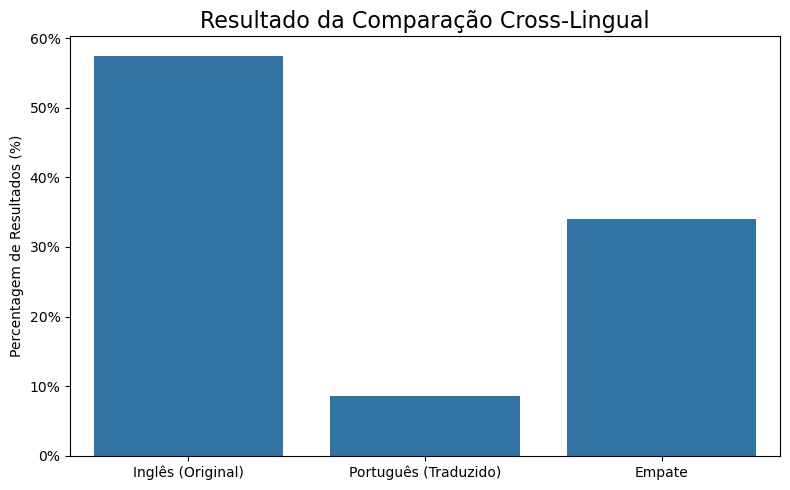

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=resultados_h2, x='Fonte da Resposta', y='Taxa de Vitória', ax=ax)
ax.set_title('Resultado da Comparação Cross-Lingual', fontsize=16)
ax.set_ylabel('Percentagem de Resultados (%)')
ax.set_xlabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.show()

In [46]:
# Análise Cross-Model
df_cross_model = df_analise[df_analise['model_of_A'].notna() & df_analise['model_of_B'].notna()].copy()

In [47]:
models = pd.unique(df_cross_model[['model_of_A', 'model_of_B']].values.ravel('K'))
models

array(['gemini-1.5-pro-latest', 'sabia-3.1', 'gpt-4o',
       'llama-3.3-70b-versatile'], dtype=object)

In [49]:
win_rate_matrix = pd.DataFrame(index=models, columns=models, dtype=float)

for model_row in models:
    for model_col in models:
        if model_row == model_col:
            continue # Não compara um modelo com ele mesmo
        
        # Filtra os confrontos entre os dois modelos
        subset = df_cross_model[
            ((df_cross_model['model_of_A'] == model_row) & (df_cross_model['model_of_B'] == model_col)) |
            ((df_cross_model['model_of_A'] == model_col) & (df_cross_model['model_of_B'] == model_row))
        ]
        
        if len(subset) == 0:
            continue

        wins_model_row = 0
        for _, row in subset.iterrows():
            if row['gold_winner'] == 'A' and row['model_of_A'] == model_row:
                wins_model_row += 1
            elif row['gold_winner'] == 'B' and row['model_of_B'] == model_row:
                wins_model_row += 1
        
        win_rate_matrix.loc[model_row, model_col] = wins_model_row / len(subset)

In [51]:
print("\n" + "="*70)
print("RESULTADOS CROSS-MODEL: Matriz de Taxa de Vitória")
print("="*70)
print("Lê-se: a linha X teve uma taxa de vitória de Y% contra a coluna Z.")
print(win_rate_matrix.fillna('-').applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x))


RESULTADOS CROSS-MODEL: Matriz de Taxa de Vitória
Lê-se: a linha X teve uma taxa de vitória de Y% contra a coluna Z.
                        gemini-1.5-pro-latest sabia-3.1  gpt-4o  \
gemini-1.5-pro-latest                       -    26.26%  39.02%   
sabia-3.1                              30.30%         -  28.41%   
gpt-4o                                 28.05%    27.27%       -   
llama-3.3-70b-versatile                30.86%    21.43%  21.21%   

                        llama-3.3-70b-versatile  
gemini-1.5-pro-latest                    41.98%  
sabia-3.1                                37.14%  
gpt-4o                                   36.36%  
llama-3.3-70b-versatile                       -  


/var/folders/lr/rv52d6g56jbdxpkrbhsvqjzr0000gn/T/ipykernel_83707/3345577371.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(win_rate_matrix.fillna('-').applymap(lambda x: f'{x:.2%}' if isinstance(x, float) else x))


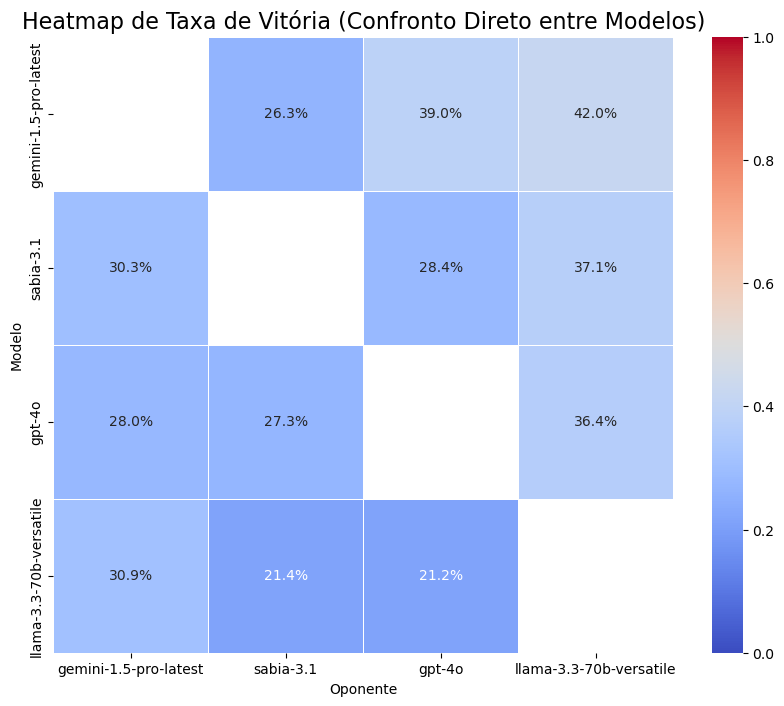

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    win_rate_matrix, 
    annot=True, 
    fmt=".1%", 
    cmap="coolwarm", 
    linewidths=.5,
    vmin=0, 
    vmax=1
)
plt.title('Heatmap de Taxa de Vitória (Confronto Direto entre Modelos)', fontsize=16)
plt.xlabel('Oponente')
plt.ylabel('Modelo')
plt.show()